In [167]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib import font_manager

plt.rcParams.update({
    "figure.dpi": 200,
    "pdf.fonttype": 42,
    "ps.fonttype": 42,
    "text.usetex": False,
})

COLOURS = {
    "blue":   "#A8D8FF",
    "purple": "#D7B9FF",
    "orange": "#FFD699",
}

def pick_font(candidates):
    """Return the first font family available from the list."""
    for name in candidates:
        try:
            font_manager.findfont(font_manager.FontProperties(family=name), fallback_to_default=False)
            return name
        except Exception:
            continue
    # final fallback to a generic mono
    return "monospace"

def register_local_font(ttf_path: str, family_name: str):
    """Optionally register a .ttf on disk and refer to it by family_name."""
    font_manager.fontManager.addfont(ttf_path)
    # After adding, matplotlib can reference it via its internal family name.
    return family_name

# Good typewriter-style candidates (closest to LaTeX \texttt):
TYPEWRITER_CANDIDATES = [
    "CMU Typewriter Text",   # Computer Modern Typewriter (if installed)
    "Latin Modern Mono",     # very close to LaTeX
    "Courier New",           # classic typewriter
    "Liberation Mono",       # metric-compatible Courier
    "DejaVu Sans Mono",      # okay fallback
]

SERIF_CANDIDATES = [
    "Times New Roman", "Times", "Nimbus Roman", "DejaVu Serif", "Liberation Serif"
]

MONO_FONT = pick_font(TYPEWRITER_CANDIDATES)
SERIF_FONT = pick_font(SERIF_CANDIDATES)

MONO_FONT, SERIF_FONT


('Courier New', 'Times New Roman')

In [168]:
# --- helpers (put once near the top) ---
def px_to_data(ax, dx=0, dy=0):
    inv = ax.transData.inverted()
    x0, y0 = inv.transform((0, 0))
    x1, y1 = inv.transform((dx, dy))
    return (x1 - x0), (y1 - y0)


In [169]:
from matplotlib.patches import Rectangle
from matplotlib import font_manager

def _caret_positions(ax, x0, y0, text, fontsize, fontfamily):
    """
    Returns a list caret_x of length len(text)+1 such that
    caret_x[k] is the x-position after rendering text[:k].
    """
    fig = ax.figure
    # One invisible "anchor" text (for vertical metrics only)
    anchor = ax.text(x0, y0, text, fontsize=fontsize, va="baseline",
                     ha="left", fontfamily=fontfamily, alpha=0, zorder=0)
    fig.canvas.draw()
    renderer = fig.canvas.get_renderer()
    full_bbox = anchor.get_window_extent(renderer=renderer).transformed(ax.transData.inverted())
    by0, by1 = full_bbox.y0, full_bbox.y1   # keep these for rectangle heights

    caret_x = [x0]
    # Measure each prefix once; this exactly matches final layout (no ligature mismatch)
    for k in range(1, len(text)+1):
        t = ax.text(x0, y0, text[:k], fontsize=fontsize, va="baseline",
                    ha="left", fontfamily=fontfamily, alpha=0)
        fig.canvas.draw()
        bb = t.get_window_extent(renderer=renderer).transformed(ax.transData.inverted())
        caret_x.append(bb.x1)   # x after prefix of length k
        t.remove()

    anchor.remove()
    return caret_x, (by0, by1)


In [170]:
def render_highlighted_clue(clue_obj, save_as="highlighted_clue.pdf"):
    """Render crossword clue with half-open span highlights."""
    clue = clue_obj["clue"]
    ans = clue_obj["ans"]
    spans = clue_obj.get("labels", [])

    fig, ax = plt.subplots(figsize=(10, 1.8))
    ax.axis("off")

    x0, y0 = 0.05, 0.55
    fontsize = 16

    # Compute caret positions
    caret_x, (by0, by1) = _caret_positions(ax, x0, y0, clue, fontsize, SERIF_FONT)

    # padding adjustments
    pad_y_px = 2          # vertical pad in pixels
    shrink_right_px = 0.5 # trim right edge a touch to avoid overlap
    pad_y, shrink_right = px_to_data(ax, 0, pad_y_px)[1], px_to_data(ax, shrink_right_px, 0)[0]

    # draw highlight boxes
    for s, e, colour, _ in spans:
        if colour and s < e:
            x_start = caret_x[s]
            x_end = caret_x[e]
            rect = Rectangle(
                (x_start, by0 - pad_y),
                max(0, (x_end - x_start) - shrink_right),
                (by1 - by0) + 2 * pad_y,
                facecolor=COLOURS.get(colour, "#FFD699"),
                edgecolor="none",
                zorder=2
            )
            ax.add_patch(rect)

    # draw main text once (for perfect spacing)
    ax.text(x0, y0, clue, fontsize=fontsize, va="baseline",
            ha="left", fontfamily=SERIF_FONT, color="black", zorder=4)

    # arrow + answer
    text_end_x = caret_x[len(clue)]
    ax.text(text_end_x + 0.05, y0, "→", fontsize=18, va="center",
            ha="left", fontfamily=SERIF_FONT)
    ax.text(text_end_x + 0.10, y0, ans, fontsize=18, va="center",
            ha="left", fontfamily=MONO_FONT, fontweight="bold")

    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    plt.tight_layout()
    fig.savefig(save_as, bbox_inches="tight")
    plt.show()
    print(f"✅ Saved to {save_as}")

In [171]:
def show_indices(s: str, group=10):
    """Prints index positions under the clue string for debugging spans."""
    print(s)
    print("".join(str(i % 10) for i in range(len(s))))






In [172]:
def make_spans_from_indices(items):
    """
    items: list of ([start, end], colour, label), using HALF-OPEN ranges [start, end)
    e.g. ([0, 1], "blue", "def") highlights only the very first character.
    """
    spans = []
    for (s, e), colour, label in items:
        assert 0 <= s <= e, "Spans must be half-open with s <= e"
        spans.append([s, e, colour, label])
    return spans


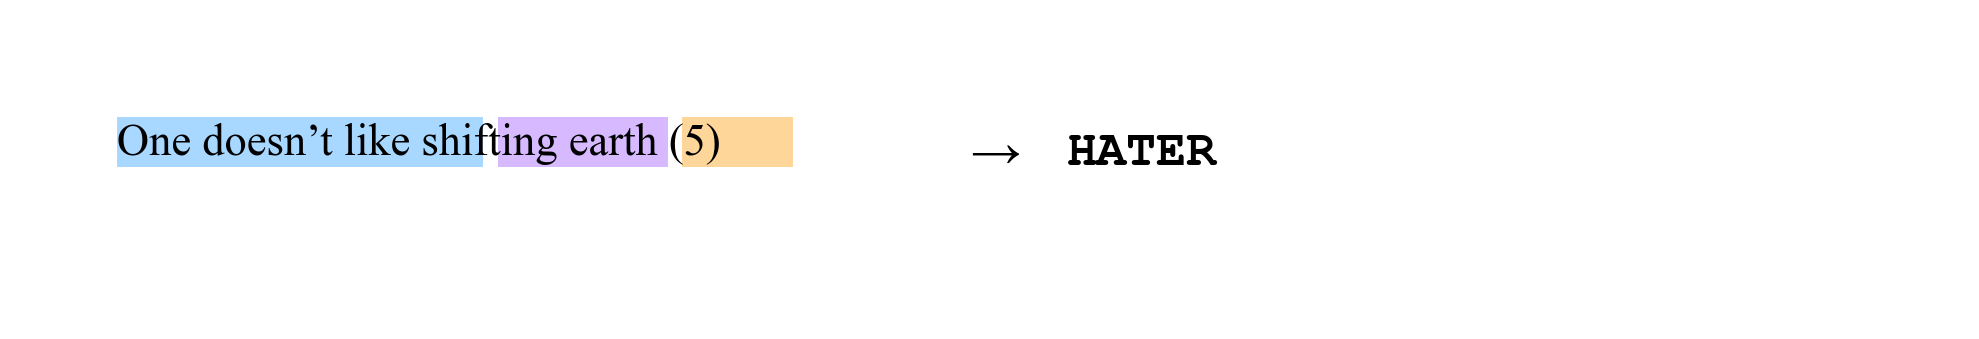

✅ Saved to highlighted_hater_fixed.pdf


In [173]:
clue_text = "One doesn’t like shifting earth (5)"
ans_text  = "HATER"

items = [
    ([0, 16], "blue",   "definition"),  # "One doesn’t like"
    ([17, 25], "purple","indicator"),   # "shifting"
    ([26, 31], "orange","fodder"),      # "earth"
]
spans = make_spans_from_indices(items)

clue1 = {"clue": clue_text, "ans": ans_text, "labels": spans}
render_highlighted_clue(clue1, save_as="highlighted_hater_fixed.pdf")
